In [1]:
import os, sys, re, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from os.path import join, exists

In [2]:
def average_df(df):
    exp_list = get_expname_and_number(list(df["expname"]))
    categories = ["accuracy_3s", "accuracy_10s", "accuracy_30s",
                     "c_primary_3s", "c_primary_10s", "c_primary_30s"]
    avg_categories = get_mean_std_category_list(categories)
    df_results = pd.DataFrame(columns=["expname", "length"] + avg_categories)
    for i, exps in enumerate(exp_list):
        expname = exps[0]
        length = get_length_from_expname(expname)
        df_results.loc[i] = [expname, length ,-1, -1, -1, -1, -1, -1, 
                             -1, -1, -1, -1, -1, -1]
        for category in categories:
            indices = []
            for exp in exps:
                idx = df[df["expname"] == exp].index[0]
                indices.append(idx)
            vals = list(df[category].loc[indices])
            vals = list(extract_nums(vals))
            mean = np.mean(vals)
            std = np.std(vals)
            df_results["mean_" + category].loc[i] = mean
            df_results["std_" + category].loc[i] = std
    df_results = df_results.sort_values("length")
    df_results = df_results.reset_index(drop=True)
    return df_results
            
def extract_nums(vals):
    for item in vals:
        try:
            yield float(item)
        except ValueError:
            pass
        
def get_length_from_expname(expname):
    if expname[-2] == "_":
        string = expname[:-2]
    else:
        string = expname
    return [int(s) for s in string.split("_") if s.isdigit()][0]
        
def get_mean_std_category_list(categories):
    list_out = []
    for cat in categories:
        list_out.append("mean_" + cat)
        list_out.append("std_" + cat)
    return list_out
    
def get_expname_and_number(expnames):
    exp_list = []
    found_names = []
    counts = []
    for exp in expnames:
        if exp[-2] == "_":
            name = exp[:-2]
        else:
            name = exp
        if name not in found_names:
            found_names.append(name)
            counts.append(1)
        else:
            idx = found_names.index(name)
            counts[idx] += 1
    for idx, name in enumerate(found_names):
        count = counts[idx]
        name_list = [name]
        if count > 1:
            for i in range(2, count + 1):
                new_name = name + "_" + str(i)
                name_list.append(new_name)
        exp_list.append(name_list)
    return exp_list

def setup_set(df, rirs, speed, clean):
    df_set = df[(df.rirs == rirs)
                & (df.speed_augmentation == speed)
                & (df.clean == clean)]
    df_set.reset_index(drop=True, inplace=True)
    return average_df(df_set)

def setup_data():

    da_summary = pd.read_csv(join(os.getcwd(), "results", "da_summary.csv"))

    baseline_results = da_summary[da_summary["baseline"] == True]
    avg_baseline = average_df(baseline_results)
    avg_baseline = avg_baseline.sort_values("length")

    avg_rirs = setup_set(da_summary, True, False, False)
    avg_rirs_clean = setup_set(da_summary, True, False, True)
    avg_aug = setup_set(da_summary, False, True, False)
    avg_aug_clean = setup_set(da_summary, False, True, True)
    avg_aug_rirs = setup_set(da_summary, True, True, False)
    avg_aug_rirs_clean = setup_set(da_summary, True, True, True)
    
    return avg_baseline, avg_rirs, avg_rirs_clean, avg_aug, avg_aug_clean, avg_aug_rirs, avg_aug_rirs_clean

def convert_category_to_label(category):
    if category == "accuracy":
        return "Accuracy"
    elif category == "c_primary":
        return "$C_{primary}$"
    
def get_combined_diff_error(baseline_val, lang_val, 
                            err_baseline, err_lang):
    #print("Baselin value: {}".format(baseline_val))
    #print("Baseline error: {}".format(err_baseline))
    #print("Lang value: {}".format(lang_val))
    #print("Lang error: {}".format(err_lang))
    D = baseline_val - lang_val
    #print(D)
    err_d_sub = (err_baseline**2 + err_lang**2) / D**2
    return D/baseline_val * (math.sqrt(err_d_sub + (err_baseline/baseline_val)**2))

def calculate_diff_and_errors(base_row, lang_row):
    diffs = list(abs(base_row[0:3] - lang_row[0:3])/base_row[0:3])
    for i in np.arange(0, 6, step=2):
        baseline_val = base_row[i]
        err_baseline = base_row[i+1]
        lang_val = lang_row[i]
        err_lang = lang_row[i+1]
        err_combined = get_combined_diff_error(baseline_val, lang_val, 
                                              err_baseline, err_lang)
        #print("Combined error: {}\n".format(err_combined))
        diffs.append(err_combined)
    return diffs

def get_diffs_and_errors(baseline_df, lang_df):
    assert(len(baseline_df) == len(lang_df)), "Lengths of DFs do not match"
    rows_out = []
    cols = ["length", "mean_c_primary_3s", "mean_c_primary_10s", 
            "mean_c_primary_30s", "std_c_primary_3s",
            "std_c_primary_10s", "std_c_primary_30s"]
    for index, row in baseline_df.iterrows():
        length = row.length
        lang_row = lang_df.loc[lang_df["length"] == length]
        assert len(lang_row) == 1, "Language row should be length 1"
        base_row = np.asarray(row.values[2:8])
        lang_row = np.asarray(lang_row.values[0][2:8])
        diff_row = calculate_diff_and_errors(base_row, lang_row)
        rows_out.append([length] + diff_row)
    return pd.DataFrame(rows_out, columns=cols)

def plot_compare(df_1, df_2, df_3, time, labels,
                 extra_df=None, savename=None, cmap=None, legend_loc="best", size=(10,4)):
    assert len(df_1) > 0, "Augmented dataframe is empty"
    assert len(df_2) > 0, "Clean dataframe is empty"
    assert len(df_3) > 0, "Baseline dataframe is empty"
    assert len(df_1) == len(df_2) and len(df_3) == len(df_2), \
            "Dataframe lengths do not match"
    
    fig, axs = plt.subplots(1, 2, figsize=size)
    for j, category in enumerate(["accuracy", "c_primary"]):
        mean_str = "mean_" + category + "_" + str(time) + "s"
        std_str = "std_" + category + "_" + str(time) + "s"
        all_data = [list(df_1[mean_str]), list(df_2[mean_str]), list(df_3[mean_str])] 
        all_errs = [list(df_1[std_str]), list(df_2[std_str]), list(df_3[std_str])]
        if extra_df is not None:
            all_data.append(list(extra_df[mean_str]))
            all_errs.append(list(extra_df[std_str]))

        min_data = min([min(x) for x in all_data])
        max_data = max([max(x) for x in all_data])
        bottom_padding = min_data * 0.05
        top_padding = max_data * 0.02

        bar_width = 0.2
        rs = [np.arange(len(all_data[0]))]
        for i in range(1, len(all_data)):
            rs.append([x + bar_width for x in rs[i-1]])

        for i in range(0, len(all_data)):    
            axs[j].bar(rs[i], all_data[i], yerr=all_errs[i], 
                    width=bar_width, label=labels[i])

        if category == "accuracy":
            axs[j].set_ylim((min_data - bottom_padding, max_data + top_padding))
        else:
            axs[j].set_ylim((0, max_data + top_padding))
        axs[j].legend(loc=legend_loc)

        axs[j].set_xlabel("Training data per language (s)")
        axs[j].set_ylabel(convert_category_to_label(category))

        x_tick_labels = ["500", "1000", "5000", "10000"]
        if extra_df is None:
            tick_locs = rs[1]
        else:
            tick_locs = [x + 0.1 for x in rs[1]]
        axs[j].set_xticks(tick_locs)
        axs[j].set_xticklabels(x_tick_labels)
    
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename + ".pdf", bbox_inches="tight")

In [3]:
baseline, rirs, rirs_clean, aug, aug_clean, aug_rirs, aug_rirs_clean = setup_data()

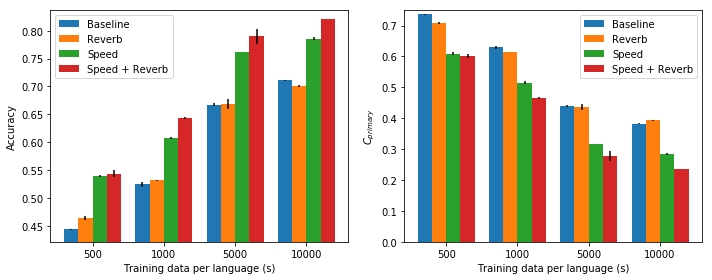

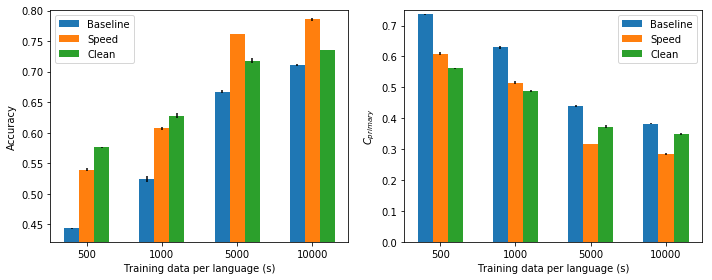

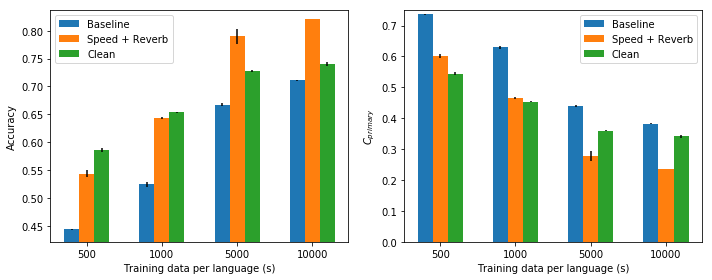

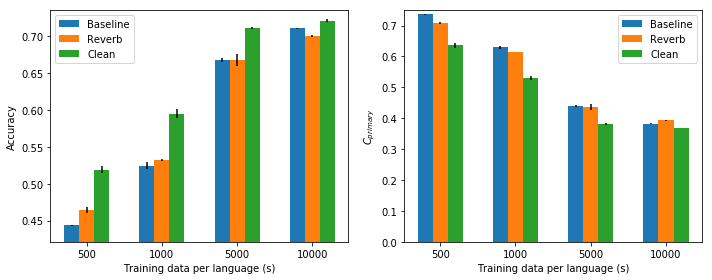

In [6]:
labels = ["Baseline","Reverb", "Speed", "Speed + Reverb"]
plot_compare(baseline, rirs, aug, 3, labels, extra_df=aug_rirs, savename="da_compare_all_3")


plot_compare(baseline, aug, aug_clean, 3, ["Baseline","Speed", "Clean"],
             savename="da_aug_all_3")   
plot_compare(baseline, aug_rirs, aug_rirs_clean, 3, ["Baseline", "Speed + Reverb", "Clean"], 
             savename="da_aug_rirs_all_3")

plot_compare(baseline, rirs, rirs_clean, 3, ["Baseline", "Reverb", "Clean"], 
             savename="da_rirs_all_3")



In [62]:
diff = get_diffs_and_errors(baseline, aug_rirs_clean)